Epoch [1/128], Loss: 0.9301, Val Loss: 0.8634, R² Score (Train): 0.1582, R² Score (Val): 0.1549
Epoch [2/128], Loss: 0.8504, Val Loss: 0.8313, R² Score (Train): 0.1927, R² Score (Val): 0.1863
Epoch [3/128], Loss: 0.8273, Val Loss: 0.8206, R² Score (Train): 0.2067, R² Score (Val): 0.1967
Epoch [4/128], Loss: 0.8134, Val Loss: 0.8137, R² Score (Train): 0.2163, R² Score (Val): 0.2034
Epoch [5/128], Loss: 0.8013, Val Loss: 0.8082, R² Score (Train): 0.2248, R² Score (Val): 0.2088
Epoch [6/128], Loss: 0.7952, Val Loss: 0.8054, R² Score (Train): 0.2311, R² Score (Val): 0.2116
Epoch [7/128], Loss: 0.7896, Val Loss: 0.8022, R² Score (Train): 0.2369, R² Score (Val): 0.2147
Epoch [8/128], Loss: 0.7802, Val Loss: 0.7988, R² Score (Train): 0.2433, R² Score (Val): 0.2180
Epoch [9/128], Loss: 0.7761, Val Loss: 0.7975, R² Score (Train): 0.2482, R² Score (Val): 0.2193
Epoch [10/128], Loss: 0.7698, Val Loss: 0.7945, R² Score (Train): 0.2542, R² Score (Val): 0.2222
Epoch [11/128], Loss: 0.7656, Val Loss:

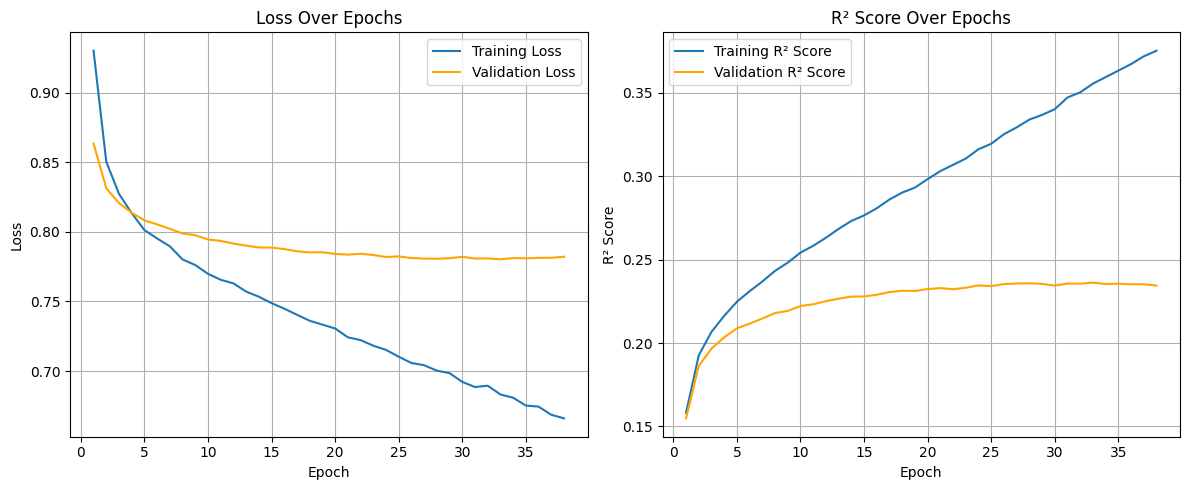

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# File Paths & Load Data
data_directory = os.path.join(os.getcwd(), "data")
train_file_path = os.path.join(data_directory, "train.csv")
test_file_path = os.path.join(data_directory, "test.csv")
train_img_dir = os.path.join(data_directory, "train_images")
test_img_dir = os.path.join(data_directory, "test_images")
train_set = np.genfromtxt(train_file_path, delimiter=',', skip_header=1)
features = train_set[:, 1:164]
ids = train_set[:, 0].astype(int)
X4 = train_set[:, 164]
X11 = train_set[:, 165]
X18 = train_set[:, 166]
X26 = train_set[:, 167]
X50 = train_set[:, 168]
X3112 = train_set[:, 169]
train_data = [features, X4, X11, X18, X26, X50, X3112]

# Data Processing 
scaler_features = StandardScaler()
normalized_features = scaler_features.fit_transform(features)
targets = np.array(train_data[1:]).T
scaler_targets = StandardScaler()
normalized_targets = scaler_targets.fit_transform(targets)

class CustomDataset(Dataset):
    def __init__(self, ids, img_dir, transform=None):
        self.ids = ids
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpeg")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(ids=ids, img_dir=train_img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

model_pre = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model_pre = torch.nn.Sequential(*list(model_pre.children())[:-1])
model_pre = model_pre.to(device)

# Use Resnet18 To Get Features From Images
features_list = []
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        features = model_pre(batch)
        features_list.append(features.cpu().squeeze())

features_tensor = torch.cat(features_list, dim=0)
features_array = features_tensor.numpy()

scaler_flattened_features = StandardScaler()
normalized_flattened_features = scaler_flattened_features.fit_transform(features_array)

combined_features = np.hstack((normalized_flattened_features, normalized_features))
combined_features_tensor = torch.tensor(combined_features, dtype=torch.float32)
targets_tensor = torch.tensor(normalized_targets, dtype=torch.float32)

dataset = TensorDataset(combined_features_tensor, targets_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# My Model
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        return self.fc(x)

model_nn = NN(input_size=675, output_size=6)
model_nn = model_nn.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.00001)  

early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

num_epochs = 128  
train_losses, val_losses = [], []
train_r2_scores, val_r2_scores = [], []

for epoch in range(num_epochs):
    model_nn.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_nn.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_nn(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    with torch.no_grad():
        train_outputs = model_nn(combined_features_tensor[train_dataset.indices].to(device))
        val_outputs = model_nn(combined_features_tensor[val_dataset.indices].to(device))
        train_r2 = r2_score(targets_tensor[train_dataset.indices].cpu(), train_outputs.cpu())
        val_r2 = r2_score(targets_tensor[val_dataset.indices].cpu(), val_outputs.cpu())
        train_r2_scores.append(train_r2)
        val_r2_scores.append(val_r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
          f'R² Score (Train): {train_r2:.4f}, R² Score (Val): {val_r2:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_r2_scores) + 1), train_r2_scores, label='Training R² Score')
plt.plot(range(1, len(val_r2_scores) + 1), val_r2_scores, label='Validation R² Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Score Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
test_set = np.genfromtxt(test_file_path, delimiter=',', skip_header=1)
test_features = test_set[:, 1:164]
test_ids = test_set[:, 0].astype(int)
normalized_test_features = scaler_features.transform(test_features)
test_dataset = CustomDataset(ids=test_ids, img_dir=test_img_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_features_list = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        img_features = model_pre(batch) 
        test_features_list.append(img_features.cpu().squeeze())

test_features_tensor = torch.cat(test_features_list, dim=0)
test_features_array = test_features_tensor.numpy()

normalized_test_img_features = scaler_flattened_features.transform(test_features_array)
combined_test_features = np.hstack((normalized_test_img_features, normalized_test_features))
combined_test_features_tensor = torch.tensor(combined_test_features, dtype=torch.float32)

model_nn.eval()
with torch.no_grad():
    test_outputs = model_nn(combined_test_features_tensor.to(device))
    predicted_targets = scaler_targets.inverse_transform(test_outputs.cpu().numpy())

output_file_path = os.path.join(data_directory, "submission.csv")
with open(output_file_path, 'w') as f:
    f.write("id,X4,X11,X18,X26,X50,X3112\n")
    for img_id, prediction in zip(test_ids, predicted_targets):
        f.write(f"{img_id},{','.join(map(str, prediction))}\n")

print("Saved")



Saved
